In [1]:
import json

output_path = '/home/cbolanos/experiments/audioset/labels/metrics.json'
with open(output_path, 'r') as f:  # Note the 'r' for read mode
    metrics = json.load(f)

# Now metrics contains your JSON data
print(metrics)  # or work with the data as needed

{'true_positives': {'344': 63, '72': 1976, '0': 13844, '73': 1192, '48': 27, '60': 80, '137': 8070, '27': 267, '308': 101, '81': 504, '85': 175, '328': 457, '332': 337, '329': 492, '300': 2652, '59': 54, '326': 59, '388': 83, '400': 101, '373': 68, '322': 358, '325': 105, '316': 207, '63': 44, '18': 4, '98': 557, '103': 135, '102': 151, '310': 64, '396': 443, '74': 803, '327': 30, '491': 47, '307': 560, '476': 144, '421': 70, '437': 153, '47': 70, '339': 74, '382': 65, '463': 89, '140': 245, '138': 359, '139': 198, '418': 128, '354': 95, '129': 186, '126': 290, '128': 66, '323': 109, '111': 366, '112': 91, '242': 49, '283': 119, '117': 162, '52': 41, '131': 154, '384': 105, '441': 40, '318': 50, '506': 129, '15': 83, '409': 108, '404': 171, '403': 96, '357': 32, '78': 89, '64': 156, '82': 80, '301': 289, '304': 78, '367': 104, '490': 78, '69': 192, '391': 50, '445': 92, '524': 16, '90': 141, '86': 245, '91': 125, '230': 2, '319': 125, '503': 28, '501': 80, '204': 21, '385': 67, '389': 

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def analyze_confusion_matrix(metrics, id2label=None, top_k=10):
    """
    Analyze and visualize confusion matrix metrics in multiple ways.
    
    Args:
        metrics (dict): Dictionary containing confusion matrix metrics
        id2label (dict): Optional mapping from class ID to label name
        top_k (int): Number of top classes to show in detailed analysis
    """
    # 1. Calculate per-class metrics
    class_metrics = []
    
    # Get all unique class indices from the metrics
    class_indices = set()
    for metric_type in ['true_positives', 'false_positives', 'true_negatives', 'false_negatives']:
        class_indices.update(metrics[metric_type].keys())
    
    for i in class_indices:
        # Access metrics using the same key type (integer)
        tp = metrics['true_positives'].get(i, 0)
        fp = metrics['false_positives'].get(i, 0)
        tn = metrics['true_negatives'].get(i, 0)
        fn = metrics['false_negatives'].get(i, 0)
        
        total = tp + fp + tn + fn
        support = tp + fn
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        class_name = id2label[i] if id2label and i in id2label else f"Class {i}"
        
        class_metrics.append({
            'class': class_name,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support,
            'total_samples': total,
            'class_idx': i
        })
    
    # Convert to DataFrame for easier analysis
    df_metrics = pd.DataFrame(class_metrics)
    
    # 2. Plot overall distribution of metrics
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.hist(df_metrics['precision'], bins=20)
    plt.title('Distribution of Precision')
    plt.xlabel('Precision')
    
    plt.subplot(132)
    plt.hist(df_metrics['recall'], bins=20)
    plt.title('Distribution of Recall')
    plt.xlabel('Recall')
    
    plt.subplot(133)
    plt.hist(df_metrics['f1'], bins=20)
    plt.title('Distribution of F1 Score')
    plt.xlabel('F1 Score')
    
    plt.tight_layout()
    plt.show()
    
    # 3. Show top and bottom performing classes
    print("\nTop {} performing classes by F1 Score:".format(top_k))
    print(df_metrics.nlargest(top_k, 'f1')[['class', 'precision', 'recall', 'f1', 'support']]
          .to_string(float_format=lambda x: '{:.3f}'.format(x) if isinstance(x, float) else str(x)))
    
    print("\nBottom {} performing classes by F1 Score:".format(top_k))
    print(df_metrics.nsmallest(top_k, 'f1')[['class', 'precision', 'recall', 'f1', 'support']]
          .to_string(float_format=lambda x: '{:.3f}'.format(x) if isinstance(x, float) else str(x)))
    
    # 4. Calculate and print overall metrics
    weighted_precision = np.average(df_metrics['precision'], weights=df_metrics['support'])
    weighted_recall = np.average(df_metrics['recall'], weights=df_metrics['support'])
    weighted_f1 = np.average(df_metrics['f1'], weights=df_metrics['support'])
    
    print("\nOverall Weighted Metrics:")
    print(f"Weighted Precision: {weighted_precision:.3f}")
    print(f"Weighted Recall: {weighted_recall:.3f}")
    print(f"Weighted F1: {weighted_f1:.3f}")
    
    # 5. Plot confusion matrix heatmap for top-k classes by support
    top_classes = df_metrics.nlargest(top_k, 'support')
    
    # Create confusion matrix for top classes
    cm_data = []
    for idx, row in top_classes.iterrows():
        class_idx = row['class_idx']
        tp = metrics['true_positives'].get(class_idx, 0)
        fp = metrics['false_positives'].get(class_idx, 0)
        fn = metrics['false_negatives'].get(class_idx, 0)
        tn = metrics['true_negatives'].get(class_idx, 0)
        cm_data.append([tp, fp, fn, tn])
    
    cm_data = np.array(cm_data)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_data, 
                annot=True, 
                fmt='d',
                xticklabels=['TP', 'FP', 'FN', 'TN'],
                yticklabels=top_classes['class'],
                cmap='YlOrRd')
    plt.title(f'Confusion Matrix Components for Top {top_k} Classes by Support')
    plt.tight_layout()
    plt.show()

# Example usage:
# metrics = calculate_confusion_matrix(base_path, df, model)
# analyze_confusion_matrix(metrics, model.config.id2label)  # id2label is optional

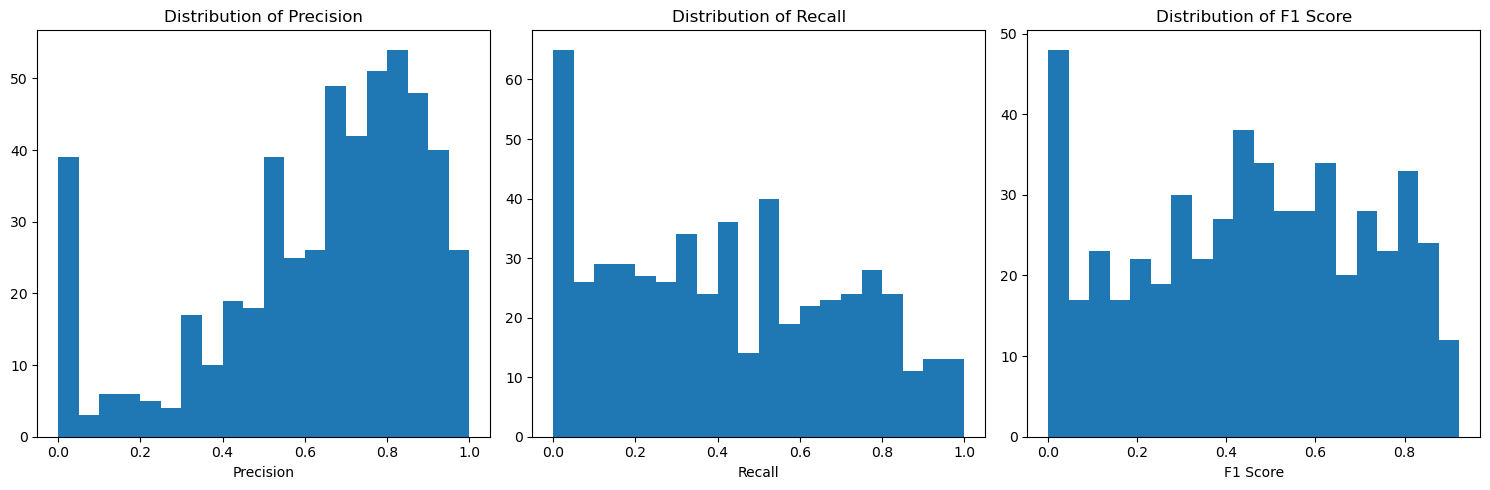


Top 10 performing classes by F1 Score:
         class  precision  recall    f1  support
130  Class 114      0.923   0.923 0.923       13
120  Class 102      0.938   0.899 0.918      168
137  Class 204      0.840   1.000 0.913       21
11    Class 91      0.856   0.977 0.912      128
27   Class 103      0.877   0.931 0.903      145
376  Class 401      0.933   0.848 0.889       33
477   Class 56      0.800   1.000 0.889        4
41    Class 58      0.958   0.827 0.888      110
229  Class 128      0.846   0.930 0.886       71
239  Class 498      0.849   0.919 0.883       86

Bottom 10 performing classes by F1 Score:
         class  precision  recall    f1  support
4    Class 274      0.000   0.000 0.000       16
5    Class 159      0.000   0.000 0.000       24
26   Class 275      0.000   0.000 0.000        3
34   Class 267      0.000   0.000 0.000       21
56   Class 260      0.000   0.000 0.000       13
58   Class 244      0.000   0.000 0.000       25
62   Class 251      0.000   0.000 0

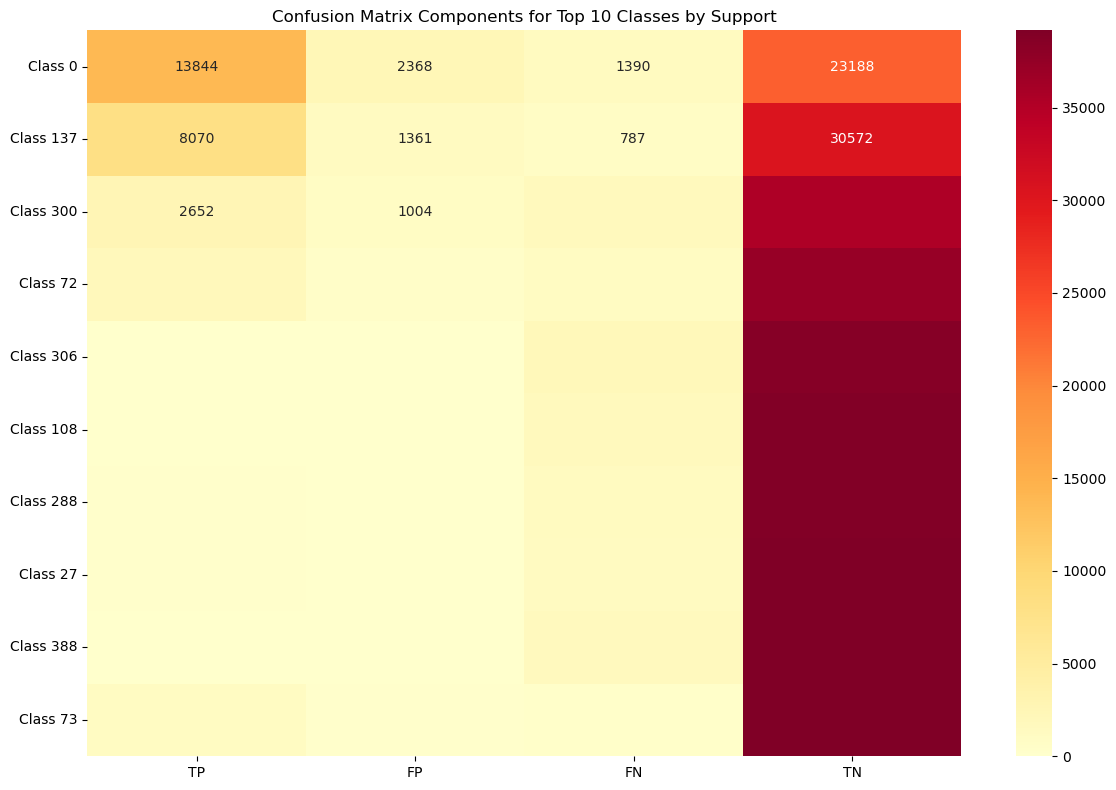

In [12]:
analyze_confusion_matrix(metrics)  # id2label is optional

In [13]:
df = pd.read_csv('/home/cbolanos/experiments/audioset/labels/labels_segments.csv')


/tmp/ipykernel_2447909/609295613.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/cbolanos/experiments/audioset/labels/labels_segments.csv')


In [14]:
df

,Unnamed: 0,segment_id,start_time_seconds,end_time_seconds,label,Unnamed: 4,base_segment_id,positive_labels,name_positive_label
0,5,NQNTnl0zaqU_70000,0.000,0.103,/m/07rdhzs,"Whack, thwack",NQNTnl0zaqU,"['/m/04rlf', '/m/07rrh0c', '/m/0c1dj']","[['Music'], ['Thump, thud', 'Thunk'], ['Other ..."
1,6,NQNTnl0zaqU_70000,0.233,0.443,/m/07rdhzs,"Whack, thwack",NQNTnl0zaqU,"['/m/04rlf', '/m/07rrh0c', '/m/0c1dj']","[['Music'], ['Thump, thud', 'Thunk'], ['Other ..."
2,7,NQNTnl0zaqU_70000,0.542,0.785,/m/07rdhzs,"Whack, thwack",NQNTnl0zaqU,"['/m/04rlf', '/m/07rrh0c', '/m/0c1dj']","[['Music'], ['Thump, thud', 'Thunk'], ['Other ..."
3,8,NQNTnl0zaqU_70000,0.940,1.208,/m/07rdhzs,"Whack, thwack",NQNTnl0zaqU,"['/m/04rlf', '/m/07rrh0c', '/m/0c1dj']","[['Music'], ['Thump, thud', 'Thunk'], ['Other ..."
4,9,NQNTnl0zaqU_70000,1.200,2.183,/m/024dl,Cash register,NQNTnl0zaqU,"['/m/04rlf', '/m/07rrh0c', '/m/0c1dj']","[['Music'], ['Thump, thud', 'Thunk'], ['Other ..."
...,...,...,...,...,...,...,...,...,...
409490,934793,B9-RtPIRHLw_30000,7.201,7.853,/m/05zppz,NaN,B9-RtPIRHLw,"['/m/01h8n0', '/m/02qldy', '/m/05zppz', '/m/09...","[['Speech', 'Conversation'], ['Speech', 'Narra..."
409491,934794,B9-RtPIRHLw_30000,8.014,8.854,/m/01w250,NaN,B9-RtPIRHLw,"['/m/01h8n0', '/m/02qldy', '/m/05zppz', '/m/09...","[['Speech', 'Conversation'], ['Speech', 'Narra..."
409492,934795,B9-RtPIRHLw_30000,8.791,10.000,/m/05zppz,NaN,B9-RtPIRHLw,"['/m/01h8n0', '/m/02qldy', '/m/05zppz', '/m/09...","[['Speech', 'Conversation'], ['Speech', 'Narra..."
409493,934796,0aPKJ8cfe3A_30000,0.000,10.000,/m/04rlf,NaN,0aPKJ8cfe3A,"['/m/04rlf', '/m/0l14qv']","[['Music'], ['Keyboard (musical)', 'Synthesize..."
